In [1]:
DEBUG = False
N_DEBUG = 20

In [2]:
import pandas as pd
import numpy as np
import transformers
import torch
import re
from tqdm import tqdm
import sklearn
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
test = pd.read_pickle("./dataset_test.pkl")


documents = test["answer"]
gold_labels = test["author"] == "human_answers" # convention: 0: machine, 1: human, see detector.py

if DEBUG and N_DEBUG > 0:
    documents = documents[0:N_DEBUG]
    gold_labels = gold_labels[0:N_DEBUG]



from gpt2outputdataset.detector_radford import DetectorRadford
from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
detector_classes = [DetectorGuo]#,DetectorDetectGPT,DetectorDetectGPT]

from explainer_wrappers import LIME_Explainer, SHAP_Explainer, Random_Explainer
explainer_classes = [SHAP_Explainer, LIME_Explainer]

In [4]:
from abc import ABC, abstractmethod
class Experiment(ABC):
    @abstractmethod 
    def __init__(self, explainer, document, gt):
        self.document = document
        self.gt = gt
        self.explainer = explainer
        self.fi_scores_machine  = self.explainer.get_fi_scores(document, fill=True)[0]
        self.fi_scores_human = self.explainer.get_fi_scores(document, fill=True)[1]
    @property
    @abstractmethod
    def modified_document(self):
        pass
    # as in Arras et al. 2016: "The target class is the true document class,[...]"
    def get_fi_scores_target(self):
        if self.gt:
            return self.fi_scores_human
        else:
            return self.fi_scores_machine
    def remove_features(self, id_fi_tuples_list, mask=True):
        tokenized_modified_document = self.explainer.tokenize(self.document)

        # two asserts to verify that approach is valid
       # print("r",expself.explainerlainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)))
       # print("o", self.document)
        # this fails: 
        # assert self.explainer.untokenize(self.explainer.tokenize(self.document, collapse_whitespace=False)) == self.document, "Merging strategy faulty"
        # see self.explainer.LIME_Explainer.untokenize
       
        ### assert right words are removed
        top_words = [word for word, fi in self.explainer.as_list(self.explainer.get_explanation_cached(self.document), label=self.gt) if fi > 0]
        for a, b in zip(tokenized_modified_document, self.explainer.tokenize(self.document)):
            if a == self.explainer.detector.get_pad_token():
                assert b in top_words, "Masking strategy faulty"
        ###
       
        ids_tokens_to_remove = []
        # don't remove anything if there are no best/worst features (e.g. only positive or only negative fi scores)
        if len(id_fi_tuples_list):
            ids_tokens_to_remove, _ = zip(*id_fi_tuples_list) 
        # replace with pad token (all detectors support partial input)
        if mask:
            for t in ids_tokens_to_remove:
                tokenized_modified_document[t] = self.explainer.detector.get_pad_token()
        else:
            tokenized_modified_document = [t for i, t in enumerate(tokenized_modified_document) if i not in ids_tokens_to_remove]
        return self.explainer.untokenize(tokenized_modified_document)

In [5]:
class Experiment_Delete_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        if self.n == 0:
            return self.document
        highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[0:self.n]
        # remove 0 scores if !include_zero_scores
        highest_fi_scores_target = [(idx, fi) for idx,fi in highest_fi_scores_target if self.include_zero_scores or (fi != 0)]

        return self.remove_features(highest_fi_scores_target, mask=self.mask)


In [6]:
class Experiment_Delete_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[0:self.n]
        # remove 0 scores if !include_zero_scores
        lowest_fi_scores_target = [(idx, fi) for idx,fi in lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(lowest_fi_scores_target, mask=self.mask)


In [7]:
class Experiment_Delete_all_except_n_Highest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):
        all_but_highest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=True)[self.n:]
        all_but_highest_fi_scores_target = [(idx, fi) for idx,fi in all_but_highest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_highest_fi_scores_target, mask=self.mask)

In [8]:
class Experiment_Delete_all_except_n_Lowest(Experiment):
    def __init__(self, explainer, document, gt, include_zero_scores=False, n=10, mask=True):
        super().__init__(explainer, document, gt)
        self.n = n
        self.include_zero_scores = include_zero_scores
        self.mask = mask
    @property
    def modified_document(self):

        all_but_lowest_fi_scores_target = sorted(self.get_fi_scores_target(), key=lambda x: x[1], reverse=False)[self.n:]
        all_but_lowest_fi_scores_target = [(idx, fi) for idx,fi in all_but_lowest_fi_scores_target if self.include_zero_scores or (fi != 0)]
        return self.remove_features(all_but_lowest_fi_scores_target, mask=self.mask)

In [9]:
prediction_cache = {}
def prediction_cached(detector, document):
    id = (detector.__class__.__name__,document)
    if id not in prediction_cache:
        prediction_cache[id] = detector.predict_proba([document])[0]
    return prediction_cache[id]


In [10]:
def get_results_row(document, gt,  explainer, experiment_class, detector, n):
    
    experiment = experiment_class(explainer, document, gt, n=n)
    p_machine_original, p_human_original  = prediction_cached(detector, experiment.document)
    y_original = p_human_original >= p_machine_original

    p_machine_modified = None
    p_human_modified = None
    if n == 0:
        assert experiment.modified_document == experiment.document # just a sanity check for the experiment classes
        p_machine_modified, p_human_modified = prediction_cached(detector, experiment.modified_document)
    else:
        p_machine_modified, p_human_modified = detector.predict_proba([experiment.modified_document])[0]

    y_modified = p_human_modified >= p_machine_modified
    return [
                    explainer.__class__.__name__, 
                    explainer.detector.__class__.__name__, 
                    n,
                    p_machine_original,
                    p_human_original,
                    y_original,
                    p_machine_modified,
                    p_human_modified,
                    y_modified,
                    gt]

In [11]:
def run_experiment(experiment_class, detector, n=10):
    results = []
    columns=["Explainer", "Detector", "n", "p_machine_original", "p_human_original", "y_original", "p_machine_modified", "p_human_modified", "y_modified", "gt"]
    for explainer_class in explainer_classes:
        explainer = explainer_class(detector)
        for document, gt in zip(documents, gold_labels):
            results.append(get_results_row(document, gt, explainer, experiment_class, detector, n))

    # random baseline (with new seeds at each run)
    for i in range(0,10):
        random_explainer = Random_Explainer(detector, seed=42-i)
        for document, gt in zip(documents, gold_labels):
            results_row = get_results_row(document, gt, random_explainer, experiment_class, detector, n)
            results_row[0] = "Random Run "+str(i)
            results.append(results_row)

    df = pd.DataFrame(results, columns=columns)

    df["p_target_original"] = df.apply(lambda x: x["p_human_original"] if x["gt"] else x["p_machine_original"], axis=1)
    df["p_target_modified"] = df.apply(lambda x: x["p_human_modified"] if x["gt"] else x["p_machine_modified"], axis=1)    
    df["drop_target"] = df["p_target_original"] - df["p_target_modified"] 

    

    return df

In [12]:
import matplotlib.pyplot as plt

## Plot like in Arras et al.

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
def get_acc_by_initial_prediction_right_wrong(df, n):
    accs = []
    for explainer_name, group in df.groupby("Explainer"):
        group_initial_right = group[group["y_original"] == group["gt"]]
        group_initial_wrong = group[group["y_original"] != group["gt"]]
        accs.append((explainer_name,accuracy_score(group_initial_right["gt"], group_initial_right["y_modified"]), accuracy_score(group_initial_wrong["gt"], group_initial_wrong["y_modified"]),n))
    return pd.DataFrame(accs, columns=["Explainer", "acc_initial_right", "acc_initial_wrong", "n"])

In [24]:
import seaborn as sns
import os

In [25]:
results_path = "./token_removal_experiments_results"

In [27]:
os.path.join(results_path, detector.__class__.__name__+".csv")

'./token_removal_experiments_results\\DetectorGuo.csv'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Running experiment with different n: 100%|██████████| 15/15 [22:09<00:00, 88.62s/it]


,Explainer,acc_initial_right,acc_initial_wrong,n
0,LIME,1.000000,0.0,0
1,Random,1.000000,0.0,0
2,Random,1.000000,0.0,0
3,Random,1.000000,0.0,0
4,Random,1.000000,0.0,0
...,...,...,...,...
7,Random,0.493377,1.0,50
8,Random,0.493377,1.0,50
9,Random,0.493377,1.0,50
10,Random,0.493377,1.0,50


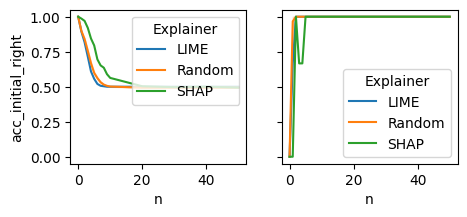

In [16]:
n_deleted_words = list(range(0,10+1)) + [20,30,40,50]


for detector_class in detector_classes:
    detector = detector_class()
    path = os.path.join(results_path, detector.__class__.__name__+".csv")
    if os.path.isfile(path):
        continue

    dfs_at_n = [(run_experiment(Experiment_Delete_n_Highest,detector, n=n), n) for n in tqdm(n_deleted_words, desc="Running experiment for "+detector.__class__.__name__)]
    df_accuracy_scores = pd.concat([get_acc_by_initial_prediction_right_wrong(df,n) for df, n in dfs_at_n])
    
    df_accuracy_scores.loc[df_accuracy_scores["Explainer"].str.startswith("Random"), "Explainer"] = "Random"
    # df_accuracy_scores.groupby(["Explainer", "n"]).mean().reset_index()

    df_accuracy_scores["Explainer"] = df_accuracy_scores["Explainer"].str.replace("_Explainer","")

    
    df_accuracy_scores.to_csv(path, encoding="UTF-8", index=False)


In [ ]:
f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=True, figsize=(5,2))
    sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
    sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)


In [17]:
dfs_at_n = [(run_experiment(Experiment_Delete_n_Highest,detector, n=n), n) for n in tqdm(n_deleted_words, desc="Running experiment with different n")]
df_accuracy_scores = pd.concat([get_acc_by_initial_prediction_right_wrong(df,n) for df, n in dfs_at_n])

df_accuracy_scores.loc[df_accuracy_scores["Explainer"].str.startswith("Random"), "Explainer"] = "Random"
# df_accuracy_scores.groupby(["Explainer", "n"]).mean().reset_index()

df_accuracy_scores["Explainer"] = df_accuracy_scores["Explainer"].str.replace("_Explainer","")
display(df_accuracy_scores)

Running experiment with different n: 100%|██████████| 15/15 [20:56<00:00, 83.73s/it]


,Explainer,acc_initial_right,acc_initial_wrong,n
0,LIME,1.000000,0.0,0
1,Random,1.000000,0.0,0
2,Random,1.000000,0.0,0
3,Random,1.000000,0.0,0
4,Random,1.000000,0.0,0
...,...,...,...,...
7,Random,0.493377,1.0,50
8,Random,0.493377,1.0,50
9,Random,0.493377,1.0,50
10,Random,0.493377,1.0,50


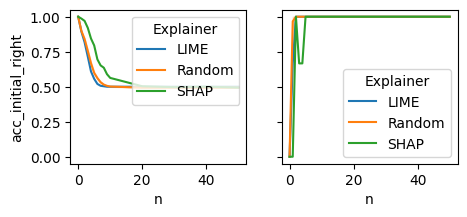

In [18]:

f, (ax_right, ax_wrong) = plt.subplots(1,2, sharey=True, figsize=(5,2))
sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_right", hue="Explainer", ax=ax_right)
sns.lineplot(data=df_accuracy_scores, x="n", y="acc_initial_wrong", hue="Explainer", ax=ax_wrong)

# random baseline

plt.show()

In [19]:


acc_scores = [(accuracy_score(df["gt"], df["y_modified"]),n) for df, n in dfs_at_n] # @ 0 removed + n removed
acc_scores

[(0.9901639344262295, 0),
 (0.9049180327868852, 1),
 (0.8508196721311475, 2),
 (0.7680327868852459, 3),
 (0.6800546448087431, 4),
 (0.6150273224043716, 5),
 (0.5734972677595629, 6),
 (0.5445355191256831, 7),
 (0.5289617486338798, 8),
 (0.5174863387978142, 9),
 (0.5112021857923498, 10),
 (0.4997267759562842, 20),
 (0.49918032786885247, 30),
 (0.4994535519125683, 40),
 (0.4989071038251366, 50)]

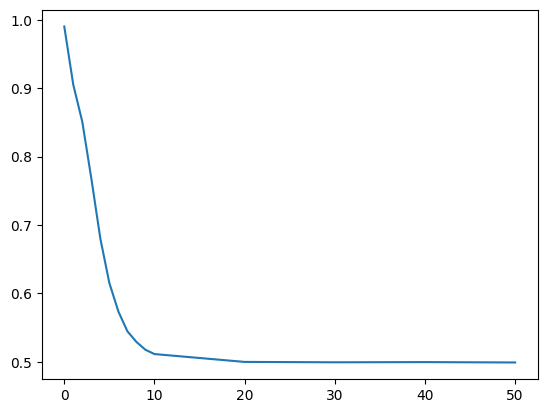

In [20]:
acc, n = zip(*acc_scores)
plt.plot(n, acc)

In [21]:
def run_experiment_incremental(experiment_class, start = 0, stop = 30):
    dfs = [run_experiment(experiment_class, n=n) for n in tqdm(range(start,stop+1), desc="Running {}".format(experiment_class.__name__))]
    df = pd.concat(dfs)
    df["drop_target"] = df["p_target_original"] - df["p_target_modified"]

    for name, group in df.groupby(["Explainer", "Detector", ]):
        print(name)
        group.reset_index()[["n", "drop_target"]].groupby("n").mean().plot()
        plt.show()

    

In [22]:
# # Experiment_Delete_n_Highest: higher drop_target is better
# df = run_experiment(Experiment_Delete_n_Highest)
# df["drop_target"] = df["p_target_original"] - df["p_target_modified"]
# df.groupby(["Explainer", "Detector"]).mean()

In [23]:
# Experiment_Delete_n_Highest: higher drop_target is better

run_experiment_incremental(Experiment_Delete_n_Highest)


Running Experiment_Delete_n_Highest:   0%|          | 0/31 [00:00<?, ?it/s]

TypeError: run_experiment() missing 1 required positional argument: 'detector'

In [ ]:
# Experiment_Delete_n_Lowest: smaller drop_target is better
run_experiment_incremental(Experiment_Delete_n_Lowest)


In [ ]:
# Experiment_Delete_all_except_n_Highest: smaller drop_target is better
run_experiment_incremental(Experiment_Delete_all_except_n_Highest)


In [ ]:
# Experiment_Delete_all_except_n_Lowest: higher drop_target is better
run_experiment_incremental(Experiment_Delete_all_except_n_Lowest)